In this notebook, we demonstrate **filtering** and **loading** of CoRE Stack data through STAC API. 

**Steps**: 
1. Connect to the API end point 
2. (Filtering condition) Choose any or all:
    1. a bounding box of interest,
    2. time period of interest 
    3. keywords
3. Filter the catalog for data layers of interest based on the condition
4. Load data of the select layers (raster or vector)

In [1]:
#!pip install pystac_client

In [2]:
from pystac_client import Client
import json
import pystac
import pandas as pd
import geopandas as gpd
from pystac import MediaType
import rasterio
import requests
import rasterio.plot

In [3]:
url = 'https://api.stac.core-stack.org/'
# url = 'http://localhost:8082/'
catalog = Client.open(url)

* **Spatial filtering** : give a bounding box of interest and filter items
    
* [bboxfinder.com](http://bboxfinder.com/) is a good tool to get bounding box of an area of interest

In [4]:
# Bounding box

bbox = [87.077057,24.086295,87.300217,24.288611] #near masalia
# bbox = [77.371763,12.719339,77.849668,13.209150] #bangalore,karnataka
# bbox = [70.535101,21.934086,71.397293,22.549155] #GJ

search = catalog.search(bbox=bbox)

count = 0
for item in search.items():
    count += 1
    # print(f"Found: {item.id}")

In [5]:
# print("matched items count = ",count)

* **Spatio Temporal filtering**: select bbox + time period of interest 

In [6]:
# Bounding box
# bbox = [85.85, 24.38, 86.25, 24.75] ##tisri
# bbox=[74.05, 11.59, 78.58, 18.45] ##karnataka

bbox = [87.077057,24.086295,87.300217,24.288611] #near masalia
# bbox = [84.575930,24.636524,86.894045,26.764732] #bihar
# bbox = [77.371763,12.719339,77.849668,13.209150] #bangalore, karnataka

search = catalog.search(
    bbox=bbox,
    datetime="2025-01-01/2025-12-31",
)

for item in search.items():
    print(f"Found: {item.id}")

Found: jharkhand_dumka_shikaripara_land_use_land_cover_raster_2024
Found: jharkhand_dumka_masalia_land_use_land_cover_raster_2024
Found: jharkhand_dumka_shikaripara_water_balance_fortnightly_vector
Found: jharkhand_dumka_shikaripara_terrain_vector
Found: jharkhand_dumka_shikaripara_terrain_raster
Found: jharkhand_dumka_shikaripara_surface_water_bodies_vector
Found: jharkhand_dumka_shikaripara_stage_of_groundwater_extraction_vector
Found: jharkhand_dumka_shikaripara_nrega_vector
Found: jharkhand_dumka_shikaripara_natural_depressions_raster
Found: jharkhand_dumka_shikaripara_drought_frequency_vector
Found: jharkhand_dumka_shikaripara_drainage_lines_vector
Found: jharkhand_dumka_shikaripara_distance_to_upstream_drainage_line_raster
Found: jharkhand_dumka_shikaripara_cropping_intensity_vector
Found: jharkhand_dumka_shikaripara_clart_raster
Found: jharkhand_dumka_shikaripara_change_in_well_depth_vector
Found: jharkhand_dumka_shikaripara_catchment_area_singleflow_raster
Found: jharkhand_dumk

* **Keywords filtering**: filtering based on layer keywords

In [7]:
search = catalog.search(
    bbox=bbox,
    filter_lang="cql2-json",
    filter={
      "op": "a_contains",
      "args": [
        {"property": "keywords"},
        "terrain"
        # "administrative"
        # "land use"
        # "water structure planning"
      ]
    }
)

for item in search.items():
    print(f"Found: {item.id}")

Found: jharkhand_dumka_shikaripara_terrain_vector
Found: jharkhand_dumka_shikaripara_terrain_raster
Found: jharkhand_dumka_masalia_terrain_vector
Found: jharkhand_dumka_masalia_terrain_raster
Found: jharkhand_dumka_kathikund_terrain_raster


* #### **Load data of selected items**

1. Loading a Vector data : Select id of the item of interest from the search result and load it

In [8]:
vector_item = catalog.get_item(id='jharkhand_dumka_masalia_cropping_intensity_vector')
# vector_item = catalog.get_item(id='karnataka_bengaluru_urban_anekal_admin_boundaries_vector')

In [9]:
# vector_item

In [10]:
vector_item.assets['data'].href

'https://geoserver.core-stack.org:8443/geoserver/crop_intensity/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=crop_intensity:dumka_masalia_intensity&outputFormat=application/json'

In [11]:
vector_data_df = gpd.GeoDataFrame.from_file(vector_item.assets['data'].href)

In [12]:
vector_data_df.head()

,area_in_ha,cropping_intensity_2017,cropping_intensity_2018,cropping_intensity_2019,cropping_intensity_2020,cropping_intensity_2021,cropping_intensity_2022,cropping_intensity_2023,cropping_intensity_2024,doubly_cropped_area_2017,...,triply_cropped_area_2017,triply_cropped_area_2018,triply_cropped_area_2019,triply_cropped_area_2020,triply_cropped_area_2021,triply_cropped_area_2022,triply_cropped_area_2023,triply_cropped_area_2024,uid,geometry
0,771.728344,1.543360,1.592989,1.627989,1.579311,1.533926,1.591896,1.749995,1.669949,205.898274,...,7.596099,6.770413,49.767600,6.412422,29.306040,2.696889,69.853958,89.165643,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24...."
1,847.832509,0.933263,1.054730,0.962435,1.038555,0.895486,1.047503,1.513780,1.294424,35.191767,...,9.841107,9.502951,14.673246,8.851680,14.347088,4.029576,28.882271,36.374633,12_344879,"MULTIPOLYGON (((87.24821 24.14469, 87.24821 24..."
2,1528.045314,1.623742,1.490047,2.009765,1.695151,1.675955,1.709405,1.417724,1.634267,519.313048,...,10.387465,2.376741,171.642256,4.199053,6.530095,2.938390,25.846949,72.504461,12_349531,"MULTIPOLYGON (((87.28297 24.09538, 87.28297 24..."
3,1055.627014,1.583523,1.635800,1.932067,1.729595,1.741252,1.646135,1.352155,1.670557,412.844527,...,4.227215,2.579079,103.195653,2.203542,38.080058,1.002135,25.625159,100.586456,12_352646,"MULTIPOLYGON (((87.22072 24.08325, 87.22072 24..."
4,610.230564,1.523093,1.722255,1.763636,1.633273,1.695550,1.650746,1.684141,1.538312,213.185629,...,2.089368,2.519594,17.815055,1.561420,10.238013,0.549859,26.301421,7.409542,12_365593,"MULTIPOLYGON (((87.19404 24.06007, 87.19404 24..."


In [13]:
# vector_data_df.columns

In [14]:
vector_data_df.columns[vector_data_df.columns.str.contains('intensity')]

Index(['cropping_intensity_2017', 'cropping_intensity_2018',
       'cropping_intensity_2019', 'cropping_intensity_2020',
       'cropping_intensity_2021', 'cropping_intensity_2022',
       'cropping_intensity_2023', 'cropping_intensity_2024'],
      dtype='object')

In [15]:
filter_columns = vector_data_df.columns[vector_data_df.columns.str.contains('intensity|uid|geometry')]
filter_columns

Index(['cropping_intensity_2017', 'cropping_intensity_2018',
       'cropping_intensity_2019', 'cropping_intensity_2020',
       'cropping_intensity_2021', 'cropping_intensity_2022',
       'cropping_intensity_2023', 'cropping_intensity_2024', 'uid',
       'geometry'],
      dtype='object')

Select a **microwatershed**

In [16]:
vector_data_filtered_df = vector_data_df[filter_columns]

In [17]:
# vector_data_filtered_df['uid']

In [18]:
vector_data_mws_df = vector_data_filtered_df[vector_data_filtered_df['uid'] == vector_data_filtered_df['uid'].iloc[0]]
vector_data_mws_df

,cropping_intensity_2017,cropping_intensity_2018,cropping_intensity_2019,cropping_intensity_2020,cropping_intensity_2021,cropping_intensity_2022,cropping_intensity_2023,cropping_intensity_2024,uid,geometry
0,1.54336,1.592989,1.627989,1.579311,1.533926,1.591896,1.749995,1.669949,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24...."


In [19]:
vector_data_mws_df = vector_data_mws_df.melt(id_vars=['uid','geometry'])
vector_data_mws_df

,uid,geometry,variable,value
0,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2017,1.543360
1,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2018,1.592989
2,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2019,1.627989
3,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2020,1.579311
4,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2021,1.533926
5,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2022,1.591896
6,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2023,1.749995
7,12_305795,"MULTIPOLYGON (((87.20967 24.14415, 87.2094 24....",cropping_intensity_2024,1.669949


In [20]:
vector_data_mws_df['variable'] = vector_data_mws_df['variable'].apply(lambda x: x.replace('cropping_intensity_',''))

In [21]:
vector_data_mws_df.rename(columns={'variable':'year'},inplace=True)

In [22]:
vector_data_mws_df.rename(columns={'value':'cropping_intensity'},inplace=True)

In [23]:
# vector_data_mws_df

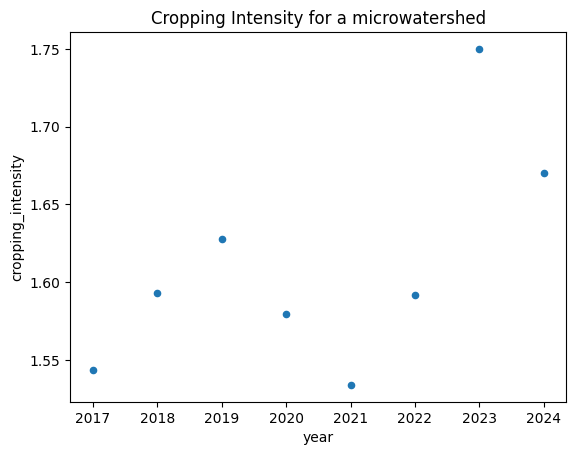

In [24]:
vector_data_mws_df.plot.scatter(x='year', y='cropping_intensity',title='Cropping Intensity for a microwatershed');

2. Loading a raster data : Select id of the item of interest from the search result and load it

Best approach to read STAC data is through odc.stac.load, however given the wcs geoserver urls, it is currently not compatible to read the raster data through odc.stac functionality. Hence we read by loading the data in the memory and reading it through rasterio. 

In [25]:
raster_item = catalog.get_item(id='jharkhand_dumka_masalia_land_use_land_cover_raster_2024')
# raster_item

In [26]:
response = requests.get(raster_item.assets['data'].href)

if response.status_code == 200:
    # Use MemoryFile to treat the downloaded bytes as a file
    with rasterio.MemoryFile(response.content) as memfile:
        with memfile.open() as src:
            print(f"CRS: {src.crs}")
            print(f"Shape: {src.shape}")
            data = src.read(1)

CRS: EPSG:4326
Shape: (3231, 4974)


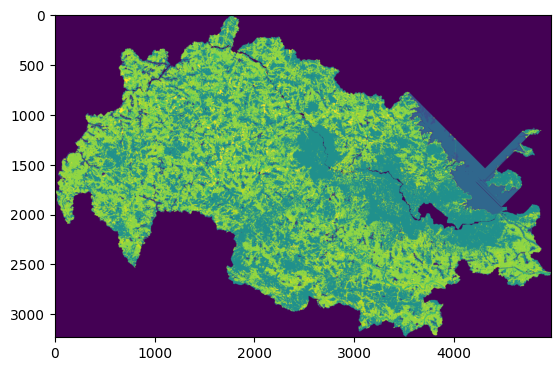

In [27]:
image_plot = rasterio.plot.show(data)